# ML4T PIPELINE - NOTEBOOK 3: MODEL TRAINING

- Goal: Train machine learning model to predict stock movements
- Input: alpha_features.h5 (from Notebook 2)
- Output: trained_model.joblib + predictions.csv

## 03 Model Training: The Intelligence Layer

This notebook implements the **Machine Learning Engine** from the ML4T framework.

**What we do:**
1. Load engineered features from Notebook 2
2. Split data using time-series methodology (no lookahead bias)
3. Train a machine learning model
4. Evaluate model performance with proper metrics
5. Analyze feature importance
6. Generate predictions for backtesting

**Output:** `trained_model.joblib` + `predictions.csv` → Ready for Backtesting (Notebook 4)


## 1. Setup & Imports

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb


In [ ]:
# Try to import CatBoost
try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("CatBoost not installed - skipping CatBoost model")

In [ ]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [ ]:
# Google Colab Drive mounting
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PATH = Path('/content/drive/MyDrive/ML4T_Pipeline')
    print("✓ Google Drive mounted successfully")
except:
    DRIVE_PATH = Path('./data')
    print("✓ Running locally - using ./data directory")

print(f"\nPython ML Libraries:")
print(f"  LightGBM version: {lgb.__version__}")
print(f"  XGBoost version: {xgb.__version__}")
if CATBOOST_AVAILABLE:
    print(f"  CatBoost version: {cb.__version__}")
else:
    print(f"  CatBoost: Not installed")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully

Python ML Libraries:
  LightGBM version: 4.6.0
  XGBoost version: 3.1.2
  CatBoost version: 1.2.8


## 2. Load Feature Data

In [ ]:
input_file = DRIVE_PATH / 'alpha_features.h5'

print(f"Loading features from: {input_file}")
features_df = pd.read_hdf(input_file, key='features')

print(f"\n✓ Features loaded successfully")
print(f"  Shape: {features_df.shape}")
print(f"  Date range: {features_df.index.get_level_values('Date').min()} to {features_df.index.get_level_values('Date').max()}")
print(f"  Tickers: {features_df.index.get_level_values('ticker').nunique()}")

print("\nColumns:")
print(features_df.columns.tolist())

Loading features from: /content/drive/MyDrive/ML4T_Pipeline/alpha_features.h5

✓ Features loaded successfully
  Shape: (24144, 27)
  Date range: 2016-01-04 00:00:00 to 2023-12-29 00:00:00
  Tickers: 12

Columns:
['close', 'high', 'low', 'open', 'volume', 'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'roc_10', 'roc_21', 'bb_upper', 'bb_lower', 'bb_percent', 'bb_width', 'atr_14', 'volatility_21', 'return_1d', 'return_5d', 'return_21d', 'forward_return_5d', 'forward_return_21d', 'volume_sma_20', 'volume_ratio', 'dollar_volume', 'volume_roc_5', 'target']


## 3. Prepare Data for ML

### 3.1 Define Features and Target

In [ ]:
# Target column
TARGET_COL = 'target'

In [ ]:
# Features to exclude from training
EXCLUDE_COLS = [
    TARGET_COL,
    'forward_return_5d',  # This is our target, can't use as feature
    'forward_return_21d',  # Future information
    'open', 'high', 'low', 'close', 'volume'  # Raw prices (we use derived features instead)
]

In [ ]:
# Get all feature columns
feature_columns = [col for col in features_df.columns if col not in EXCLUDE_COLS]

print("Feature Selection")
print(f"{'-'*60}")
print(f"Target variable: {TARGET_COL}")
print(f"Total features: {len(feature_columns)}")
print(f"Excluded columns: {EXCLUDE_COLS}")
print(f"\nSelected features:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {col}")

Feature Selection
------------------------------------------------------------
Target variable: target
Total features: 19
Excluded columns: ['target', 'forward_return_5d', 'forward_return_21d', 'open', 'high', 'low', 'close', 'volume']

Selected features:
   1. rsi_14
   2. macd
   3. macd_signal
   4. macd_hist
   5. roc_10
   6. roc_21
   7. bb_upper
   8. bb_lower
   9. bb_percent
  10. bb_width
  11. atr_14
  12. volatility_21
  13. return_1d
  14. return_5d
  15. return_21d
  16. volume_sma_20
  17. volume_ratio
  18. dollar_volume
  19. volume_roc_5


### 3.2 Handle Missing Values

In [ ]:
# Check missing values
missing_before = features_df[feature_columns + [TARGET_COL]].isnull().sum().sum()
print(f"Missing values before: {missing_before:,}")

# Drop rows with any missing values (already done in Notebook 2, but double-check)
ml_data = features_df[feature_columns + [TARGET_COL]].dropna()

missing_after = ml_data.isnull().sum().sum()
rows_dropped = len(features_df) - len(ml_data)

print(f"Missing values after: {missing_after:,}")
print(f"Rows dropped: {rows_dropped:,}")
print(f"Final dataset: {len(ml_data):,} rows")

Missing values before: 2,688
Missing values after: 0
Rows dropped: 252
Final dataset: 23,892 rows


### 3.3 Time-Series Split (Critical for No Lookahead Bias!)

In [ ]:
print("Time-Series Split Strategy")
print(f"{'-'*60}")

# Get dates
dates = ml_data.index.get_level_values('Date')

# Define split date (80/20 split approximately)
# Train: 2016-2021 (6 years)
# Test: 2022-2023 (2 years)
SPLIT_DATE = '2022-01-01'

# Create train/test masks
train_mask = dates < SPLIT_DATE
test_mask = dates >= SPLIT_DATE

# Split data
X_train = ml_data.loc[train_mask, feature_columns]
y_train = ml_data.loc[train_mask, TARGET_COL]

X_test = ml_data.loc[test_mask, feature_columns]
y_test = ml_data.loc[test_mask, TARGET_COL]

# Summary
print(f"\nSplit Strategy: Time-based (No Shuffling!)")
print(f"  Split Date: {SPLIT_DATE}")
print(f"\nTrain Set:")
print(f"  Date Range: {X_train.index.get_level_values('Date').min()} to {X_train.index.get_level_values('Date').max()}")
print(f"  Samples: {len(X_train):,}")
print(f"  Target Distribution: {y_train.value_counts().to_dict()}")
print(f"  Class Balance: {y_train.value_counts(normalize=True).to_dict()}")

print(f"\nTest Set:")
print(f"  Date Range: {X_test.index.get_level_values('Date').min()} to {X_test.index.get_level_values('Date').max()}")
print(f"  Samples: {len(X_test):,}")
print(f"  Target Distribution: {y_test.value_counts().to_dict()}")
print(f"  Class Balance: {y_test.value_counts(normalize=True).to_dict()}")

Time-Series Split Strategy
------------------------------------------------------------

Split Strategy: Time-based (No Shuffling!)
  Split Date: 2022-01-01

Train Set:
  Date Range: 2016-02-03 00:00:00 to 2021-12-31 00:00:00
  Samples: 17,880
  Target Distribution: {1: 10237, 0: 7643}
  Class Balance: {1: 0.5725391498881431, 0: 0.4274608501118568}

Test Set:
  Date Range: 2022-01-03 00:00:00 to 2023-12-29 00:00:00
  Samples: 6,012
  Target Distribution: {1: 3039, 0: 2973}
  Class Balance: {1: 0.5054890219560878, 0: 0.4945109780439122}


## 4. Model Comparison: Baseline vs Advanced

### 4.1 Define All Models

In [ ]:
print("Model Comparison Strategy")
print(f"{'-'*60}")

print("\n Models to Compare:")
print("\nBaseline Models (Linear):")
print("  1. Logistic Regression - Simple linear classifier")
print("  2. Ridge Classifier - L2 regularization")
print("  3. Lasso Classifier - L1 regularization (feature selection)")

print("\nAdvanced Models (Tree-based):")
print("  4. Random Forest - Ensemble of decision trees")
print("  5. LightGBM - Fast gradient boosting")
print("  6. XGBoost - Extreme gradient boosting")
if CATBOOST_AVAILABLE:
    print("  7. CatBoost - Categorical boosting")

Model Comparison Strategy
------------------------------------------------------------

 Models to Compare:

Baseline Models (Linear):
  1. Logistic Regression - Simple linear classifier
  2. Ridge Classifier - L2 regularization
  3. Lasso Classifier - L1 regularization (feature selection)

Advanced Models (Tree-based):
  4. Random Forest - Ensemble of decision trees
  5. LightGBM - Fast gradient boosting
  6. XGBoost - Extreme gradient boosting
  7. CatBoost - Categorical boosting


### 4.2 Initialize Models

In [ ]:
# Standardize features for linear models (tree models don't need this)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store all models
models = {}

# BASELINE MODELS

# 1. Logistic Regression
models['Logistic Regression'] = {
    'model': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'needs_scaling': True,
    'description': 'Linear baseline'
}

# 2. Ridge (using Logistic with L2)
models['Ridge'] = {
    'model': LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=42, n_jobs=-1),
    'needs_scaling': True,
    'description': 'L2 regularization'
}

# 3. Lasso (using Logistic with L1)
models['Lasso'] = {
    'model': LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=1000, random_state=42, n_jobs=-1),
    'needs_scaling': True,
    'description': 'L1 regularization'
}

# ADVANCED MODELS

# 4. Random Forest
models['Random Forest'] = {
    'model': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    ),
    'needs_scaling': False,
    'description': 'Ensemble of trees'
}

# 5. LightGBM
models['LightGBM'] = {
    'model': lgb.LGBMClassifier(
        objective='binary',
        num_leaves=31,
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=6,
        min_child_samples=50,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    'needs_scaling': False,
    'description': 'Fast gradient boosting'
}

# 6. XGBoost
models['XGBoost'] = {
    'model': xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),
    'needs_scaling': False,
    'description': 'Extreme gradient boosting'
}

# 7. CatBoost (if available)
if CATBOOST_AVAILABLE:
    models['CatBoost'] = {
        'model': cb.CatBoostClassifier(
            iterations=1000,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3,
            random_seed=42,
            verbose=False
        ),
        'needs_scaling': False,
        'description': 'Categorical boosting'
    }

print(f"\n✓ Initialized {len(models)} models")



✓ Initialized 7 models


### 4.3 Train All Models

In [ ]:
print("Training All Models")
print(f"{'-'*60}")

results = {}

for name, model_info in models.items():
    print(f"\nTraining: {name} ({model_info['description']})...")

    try:
        # Select appropriate data (scaled or not)
        if model_info['needs_scaling']:
            X_tr = X_train_scaled
            X_te = X_test_scaled
        else:
            X_tr = X_train
            X_te = X_test

        # Train model
        if name in ['LightGBM', 'XGBoost', 'CatBoost']:
            # Use early stopping for gradient boosting models
            if name == 'LightGBM':
                model_info['model'].fit(
                    X_tr, y_train,
                    eval_set=[(X_te, y_test)],
                    callbacks=[lgb.early_stopping(50, verbose=False)]
                )
            elif name == 'XGBoost':
                model_info['model'].fit(
                    X_tr, y_train,
                    eval_set=[(X_te, y_test)],
                    early_stopping_rounds=50,
                    verbose=False
                )
            elif name == 'CatBoost':
                model_info['model'].fit(
                    X_tr, y_train,
                    eval_set=(X_te, y_test),
                    early_stopping_rounds=50,
                    verbose=False
                )
        else:
            # Standard training
            model_info['model'].fit(X_tr, y_train)

        # Generate predictions
        y_train_pred_proba = model_info['model'].predict_proba(X_tr)[:, 1]
        y_test_pred_proba = model_info['model'].predict_proba(X_te)[:, 1]

        y_train_pred = (y_train_pred_proba > 0.5).astype(int)
        y_test_pred = (y_test_pred_proba > 0.5).astype(int)

        # Calculate metrics
        results[name] = {
            'train_accuracy': accuracy_score(y_train, y_train_pred),
            'test_accuracy': accuracy_score(y_test, y_test_pred),
            'train_precision': precision_score(y_train, y_train_pred),
            'test_precision': precision_score(y_test, y_test_pred),
            'train_recall': recall_score(y_train, y_train_pred),
            'test_recall': recall_score(y_test, y_test_pred),
            'train_f1': f1_score(y_train, y_train_pred),
            'test_f1': f1_score(y_test, y_test_pred),
            'train_auc': roc_auc_score(y_train, y_train_pred_proba),
            'test_auc': roc_auc_score(y_test, y_test_pred_proba),
            'y_test_pred': y_test_pred,
            'y_test_pred_proba': y_test_pred_proba,
            'model': model_info['model']
        }

        print(f"  ✓ Test AUC: {results[name]['test_auc']:.4f} | Accuracy: {results[name]['test_accuracy']:.4f}")

    except Exception as e:
        print(f"   Error: {str(e)[:100]}")
        continue

print(f"\n✓ Training complete for {len(results)} models")

Training All Models
------------------------------------------------------------

Training: Logistic Regression (Linear baseline)...
  ✓ Test AUC: 0.5072 | Accuracy: 0.5098

Training: Ridge (L2 regularization)...
  ✓ Test AUC: 0.5072 | Accuracy: 0.5098

Training: Lasso (L1 regularization)...
  ✓ Test AUC: 0.5082 | Accuracy: 0.5096

Training: Random Forest (Ensemble of trees)...
  ✓ Test AUC: 0.5262 | Accuracy: 0.5126

Training: LightGBM (Fast gradient boosting)...
  ✓ Test AUC: 0.5183 | Accuracy: 0.5098

Training: XGBoost (Extreme gradient boosting)...
   Error: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

Training: CatBoost (Categorical boosting)...
  ✓ Test AUC: 0.5323 | Accuracy: 0.5111

✓ Training complete for 6 models


### 4.4 Model Comparison Table

In [ ]:
print("MODEL COMPARISON RESULTS")
print(f"{'='*60}")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    name: {
        'Train Accuracy': f"{metrics['train_accuracy']:.4f}",
        'Test Accuracy': f"{metrics['test_accuracy']:.4f}",
        'Train AUC': f"{metrics['train_auc']:.4f}",
        'Test AUC': f"{metrics['test_auc']:.4f}",
        'Test Precision': f"{metrics['test_precision']:.4f}",
        'Test Recall': f"{metrics['test_recall']:.4f}",
        'Test F1': f"{metrics['test_f1']:.4f}",
        'Overfit (Acc)': f"{metrics['train_accuracy'] - metrics['test_accuracy']:.4f}"
    }
    for name, metrics in results.items()
}).T

print("\n Complete Performance Comparison:")
print(comparison_df)

# Find best model by test AUC
best_model_name = max(results.keys(), key=lambda x: results[x]['test_auc'])
best_model_auc = results[best_model_name]['test_auc']

print(f"\n Best Model: {best_model_name}")
print(f"   Test AUC: {best_model_auc:.4f}")
print(f"   Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")

MODEL COMPARISON RESULTS

 Complete Performance Comparison:
                    Train Accuracy Test Accuracy Train AUC Test AUC  \
Logistic Regression         0.5733        0.5098    0.5301   0.5072   
Ridge                       0.5733        0.5098    0.5301   0.5072   
Lasso                       0.5730        0.5096    0.5302   0.5082   
Random Forest               0.6195        0.5126    0.8562   0.5262   
LightGBM                    0.5831        0.5098    0.6864   0.5183   
CatBoost                    0.5788        0.5111    0.5536   0.5323   

                    Test Precision Test Recall Test F1 Overfit (Acc)  
Logistic Regression         0.5077      0.9921  0.6717        0.0635  
Ridge                       0.5077      0.9921  0.6717        0.0635  
Lasso                       0.5077      0.9924  0.6717        0.0634  
Random Forest               0.5095      0.9651  0.6669        0.1068  
LightGBM                    0.5078      0.9852  0.6702        0.0733  
CatBoost        

### 4.5 Visual Comparison

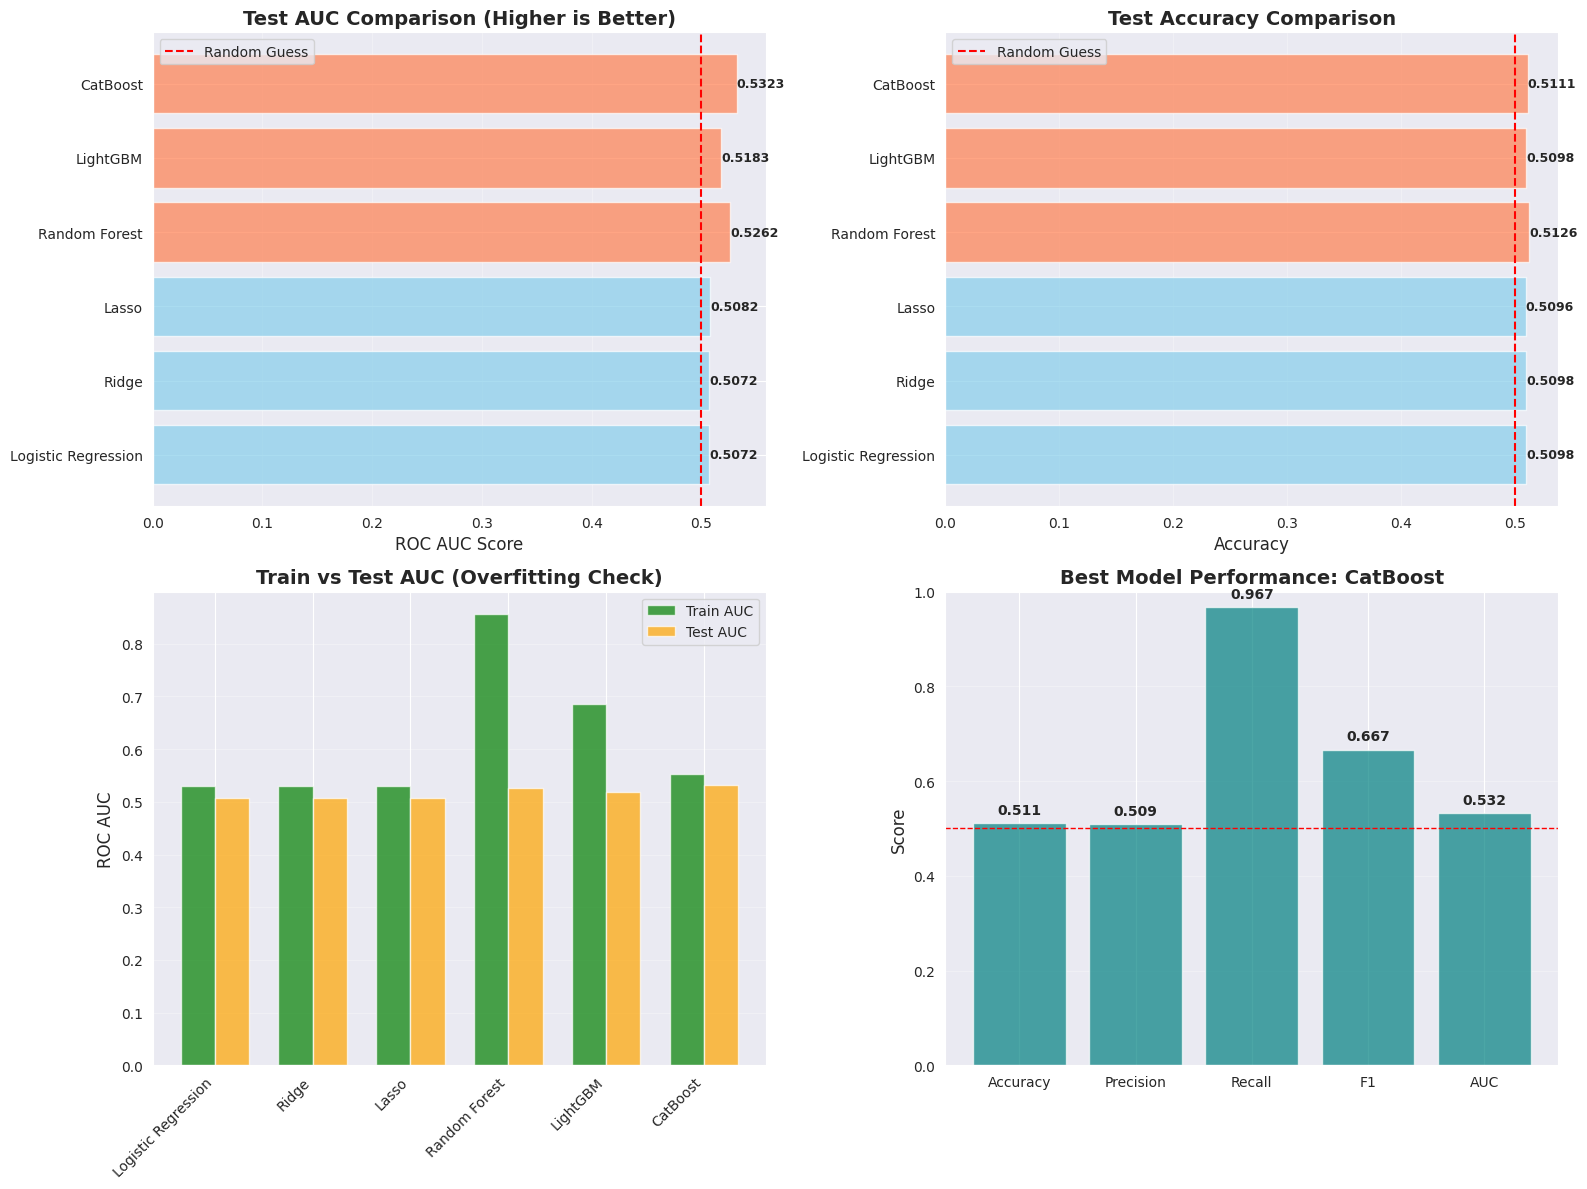

In [ ]:
def plot_model_comparison(results):
    """Visualize model performance comparison"""

    # Prepare data
    model_names = list(results.keys())
    test_auc = [results[m]['test_auc'] for m in model_names]
    test_accuracy = [results[m]['test_accuracy'] for m in model_names]
    test_f1 = [results[m]['test_f1'] for m in model_names]

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Test AUC comparison
    ax1 = axes[0, 0]
    colors = ['skyblue' if 'Logistic' in m or 'Ridge' in m or 'Lasso' in m else 'coral' for m in model_names]
    bars1 = ax1.barh(model_names, test_auc, color=colors, alpha=0.7)
    ax1.set_xlabel('ROC AUC Score', fontsize=12)
    ax1.set_title('Test AUC Comparison (Higher is Better)', fontsize=14, fontweight='bold')
    ax1.axvline(x=0.5, color='red', linestyle='--', label='Random Guess')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')

    # Add values on bars
    for bar, val in zip(bars1, test_auc):
        ax1.text(val, bar.get_y() + bar.get_height()/2, f'{val:.4f}',
                va='center', ha='left', fontsize=9, fontweight='bold')

    # 2. Test Accuracy comparison
    ax2 = axes[0, 1]
    bars2 = ax2.barh(model_names, test_accuracy, color=colors, alpha=0.7)
    ax2.set_xlabel('Accuracy', fontsize=12)
    ax2.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    ax2.axvline(x=0.5, color='red', linestyle='--', label='Random Guess')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='x')

    for bar, val in zip(bars2, test_accuracy):
        ax2.text(val, bar.get_y() + bar.get_height()/2, f'{val:.4f}',
                va='center', ha='left', fontsize=9, fontweight='bold')

    # 3. Train vs Test AUC (Overfitting check)
    ax3 = axes[1, 0]
    train_auc = [results[m]['train_auc'] for m in model_names]
    x = np.arange(len(model_names))
    width = 0.35
    ax3.bar(x - width/2, train_auc, width, label='Train AUC', alpha=0.7, color='green')
    ax3.bar(x + width/2, test_auc, width, label='Test AUC', alpha=0.7, color='orange')
    ax3.set_ylabel('ROC AUC', fontsize=12)
    ax3.set_title('Train vs Test AUC (Overfitting Check)', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(model_names, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

    # 4. Metrics Radar Chart for Best Model
    ax4 = axes[1, 1]
    best_name = max(results.keys(), key=lambda x: results[x]['test_auc'])
    best_metrics = results[best_name]

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    values = [
        best_metrics['test_accuracy'],
        best_metrics['test_precision'],
        best_metrics['test_recall'],
        best_metrics['test_f1'],
        best_metrics['test_auc']
    ]

    ax4.bar(metrics, values, color='teal', alpha=0.7)
    ax4.set_ylim([0, 1])
    ax4.set_ylabel('Score', fontsize=12)
    ax4.set_title(f'Best Model Performance: {best_name}', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

    # Add values on bars
    for i, (metric, val) in enumerate(zip(metrics, values)):
        ax4.text(i, val + 0.02, f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_model_comparison(results)

### 4.6 Select Best Model


In [ ]:
print("Best Model Selection")
print(f"{'='*60}")

# Select best model based on Test AUC
best_model_name = max(results.keys(), key=lambda x: results[x]['test_auc'])
best_model_metrics = results[best_model_name]
model = best_model_metrics['model']

# Extract predictions from best model
y_test_pred = best_model_metrics['y_test_pred']
y_test_pred_proba = best_model_metrics['y_test_pred_proba']
y_train_pred = (results[best_model_name]['model'].predict_proba(
    X_train_scaled if models[best_model_name]['needs_scaling'] else X_train
)[:, 1] > 0.5).astype(int)
y_train_pred_proba = results[best_model_name]['model'].predict_proba(
    X_train_scaled if models[best_model_name]['needs_scaling'] else X_train
)[:, 1]

print(f"\n Selected Model: {best_model_name}")
print(f"\nPerformance Summary:")
print(f"  Test AUC:       {best_model_metrics['test_auc']:.4f}")
print(f"  Test Accuracy:  {best_model_metrics['test_accuracy']:.4f}")
print(f"  Test Precision: {best_model_metrics['test_precision']:.4f}")
print(f"  Test Recall:    {best_model_metrics['test_recall']:.4f}")
print(f"  Test F1 Score:  {best_model_metrics['test_f1']:.4f}")

print(f"\nOverfitting Check:")
print(f"  Train AUC: {best_model_metrics['train_auc']:.4f}")
print(f"  Test AUC:  {best_model_metrics['test_auc']:.4f}")
print(f"  Difference: {best_model_metrics['train_auc'] - best_model_metrics['test_auc']:.4f}")

if best_model_metrics['train_auc'] - best_model_metrics['test_auc'] < 0.05:
    print("  ✓ Model generalizes well")
elif best_model_metrics['train_auc'] - best_model_metrics['test_auc'] < 0.10:
    print("  Slight overfitting, acceptable")
else:
    print("  Significant overfitting detected")

# Store for later sections
test_metrics = {
    'accuracy': best_model_metrics['test_accuracy'],
    'precision': best_model_metrics['test_precision'],
    'recall': best_model_metrics['test_recall'],
    'f1': best_model_metrics['test_f1'],
    'auc': best_model_metrics['test_auc'],
    'confusion_matrix': confusion_matrix(y_test, y_test_pred)
}

train_metrics = {
    'accuracy': best_model_metrics['train_accuracy'],
    'precision': best_model_metrics['train_precision'],
    'recall': best_model_metrics['train_recall'],
    'f1': best_model_metrics['train_f1'],
    'auc': best_model_metrics['train_auc'],
    'confusion_matrix': confusion_matrix(y_train, y_train_pred)
}


Best Model Selection

 Selected Model: CatBoost

Performance Summary:
  Test AUC:       0.5323
  Test Accuracy:  0.5111
  Test Precision: 0.5087
  Test Recall:    0.9668
  Test F1 Score:  0.6666

Overfitting Check:
  Train AUC: 0.5536
  Test AUC:  0.5323
  Difference: 0.0213
  ✓ Model generalizes well


## 5. Model Evaluation (Best Model)

In [ ]:
print("Overfitting Analysis")
print(f"{'-'*60}")

print("\nMetric Comparison (Train vs Test):")
print(f"{'Metric':<15} {'Train':<10} {'Test':<10} {'Difference':<12}")
print("-" * 50)

for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    train_val = train_metrics[metric]
    test_val = test_metrics[metric]
    diff = train_val - test_val

    status = "✓ Good" if diff < 0.05 else "⚠ Check" if diff < 0.10 else " Overfit"
    print(f"{metric.capitalize():<15} {train_val:<10.4f} {test_val:<10.4f} {diff:<12.4f} {status}")

print("\nInterpretation:")
print("  Difference < 5%:  Model generalizes well")
print("  Difference 5-10%: Slight overfitting, acceptable")
print("  Difference > 10%: Significant overfitting, review model")

Overfitting Analysis
------------------------------------------------------------

Metric Comparison (Train vs Test):
Metric          Train      Test       Difference  
--------------------------------------------------
Accuracy        0.5788     0.5111     0.0677       ⚠ Check
Precision       0.5767     0.5087     0.0681       ⚠ Check
Recall          0.9934     0.9668     0.0266       ✓ Good
F1              0.7298     0.6666     0.0632       ⚠ Check
Auc             0.5536     0.5323     0.0213       ✓ Good

Interpretation:
  Difference < 5%:  Model generalizes well
  Difference 5-10%: Slight overfitting, acceptable
  Difference > 10%: Significant overfitting, review model


## 6. Feature Importance Analysis (Best Model Only)

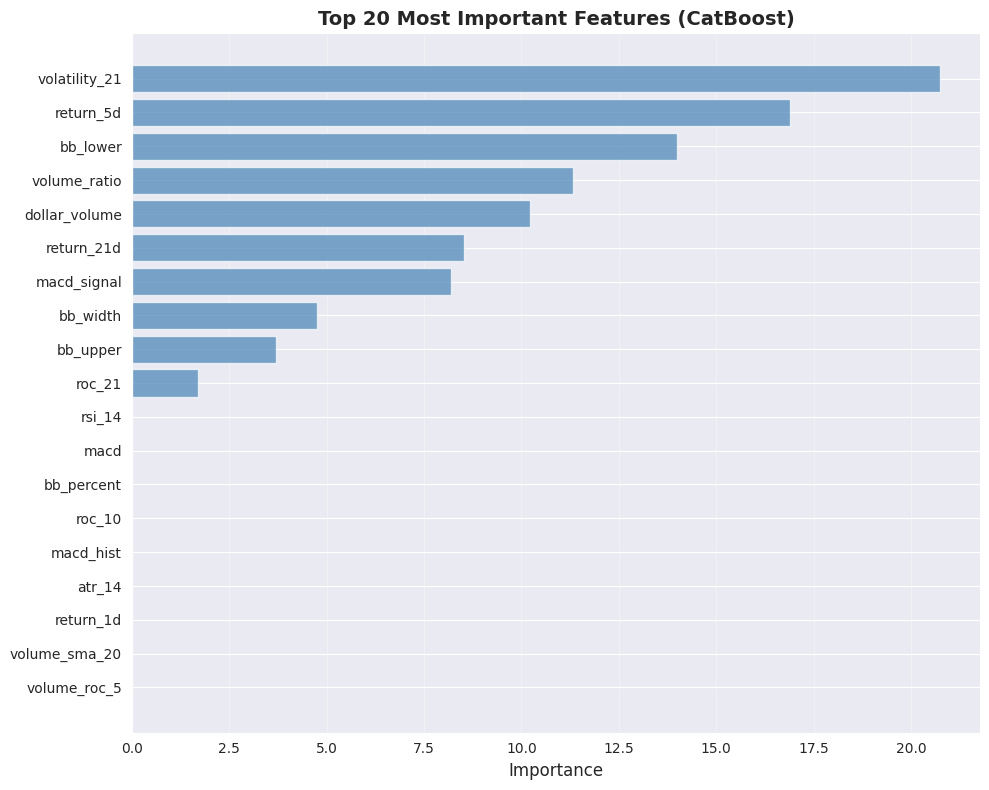


Top 20 Most Important Features (CatBoost)
      feature  importance
volatility_21   20.731840
    return_5d   16.879196
     bb_lower   14.000994
 volume_ratio   11.319718
dollar_volume   10.206274
   return_21d    8.527955
  macd_signal    8.181617
     bb_width    4.750753
     bb_upper    3.708800
       roc_21    1.692852
       rsi_14    0.000000
         macd    0.000000
   bb_percent    0.000000
       roc_10    0.000000
    macd_hist    0.000000
       atr_14    0.000000
    return_1d    0.000000
volume_sma_20    0.000000
 volume_roc_5    0.000000


In [ ]:
def plot_feature_importance(model, feature_names, model_name, top_n=20):
    """Plot feature importance from trained model"""

    # Get feature importance based on model type
    if hasattr(model, 'feature_importances_'):
        # sklearn models (RandomForest, XGBoost, LightGBM sklearn API)
        importance = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        # CatBoost
        importance = model.get_feature_importance()
    elif hasattr(model, 'coef_'):
        # Linear models (Logistic, Ridge, Lasso)
        importance = np.abs(model.coef_[0])
    else:
        print(f" Feature importance not available for {model_name}")
        return None

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    # Plot top N features
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = feature_importance.head(top_n)

    ax.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.7)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.invert_yaxis()
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(f'Top {top_n} Most Important Features ({model_name})', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    # Print top features
    print(f"\n{'='*60}")
    print(f"Top {top_n} Most Important Features ({model_name})")
    print(f"{'='*60}")
    print(feature_importance.head(top_n).to_string(index=False))

    return feature_importance

feature_importance = plot_feature_importance(
    model,
    feature_columns,
    best_model_name,
    top_n=20
)

## 7. Visualization: Model Performance

### 7.1 Confusion Matrix Heatmap

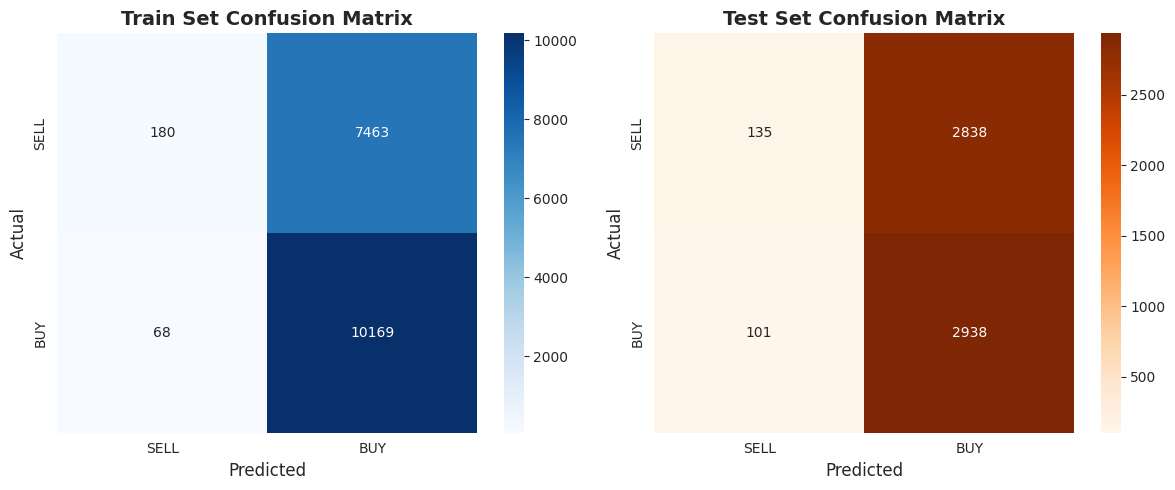

In [ ]:
def plot_confusion_matrices(train_cm, test_cm):
    """Plot confusion matrices for train and test sets"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Train confusion matrix
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['SELL', 'BUY'], yticklabels=['SELL', 'BUY'])
    axes[0].set_title('Train Set Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Actual', fontsize=12)
    axes[0].set_xlabel('Predicted', fontsize=12)

    # Test confusion matrix
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
                xticklabels=['SELL', 'BUY'], yticklabels=['SELL', 'BUY'])
    axes[1].set_title('Test Set Confusion Matrix', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Actual', fontsize=12)
    axes[1].set_xlabel('Predicted', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(train_metrics['confusion_matrix'], test_metrics['confusion_matrix'])


### 7.2 ROC Curve


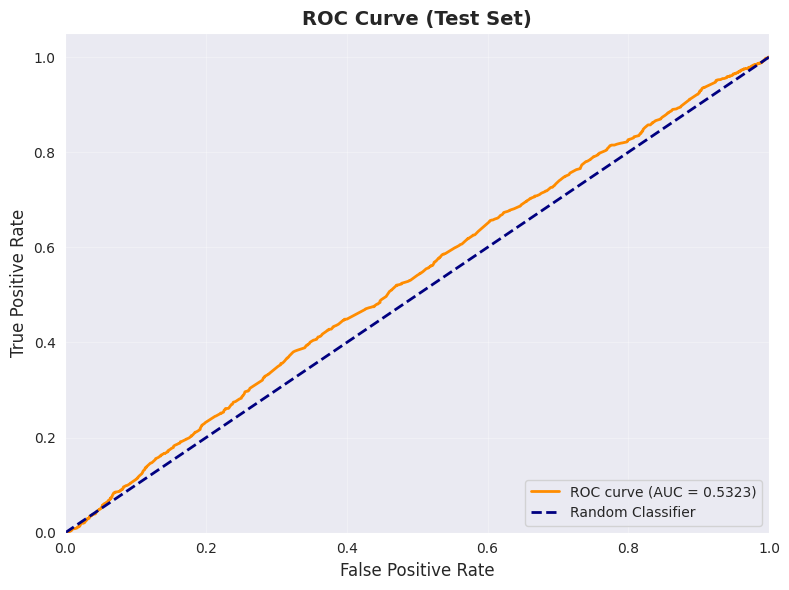

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc_curve(y_test, y_test_proba):
    """Plot ROC curve"""
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    auc = roc_auc_score(y_test, y_test_proba)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curve (Test Set)', fontsize=14, fontweight='bold')
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_roc_curve(y_test, y_test_pred_proba)

### 7.3 Prediction Probability Distribution

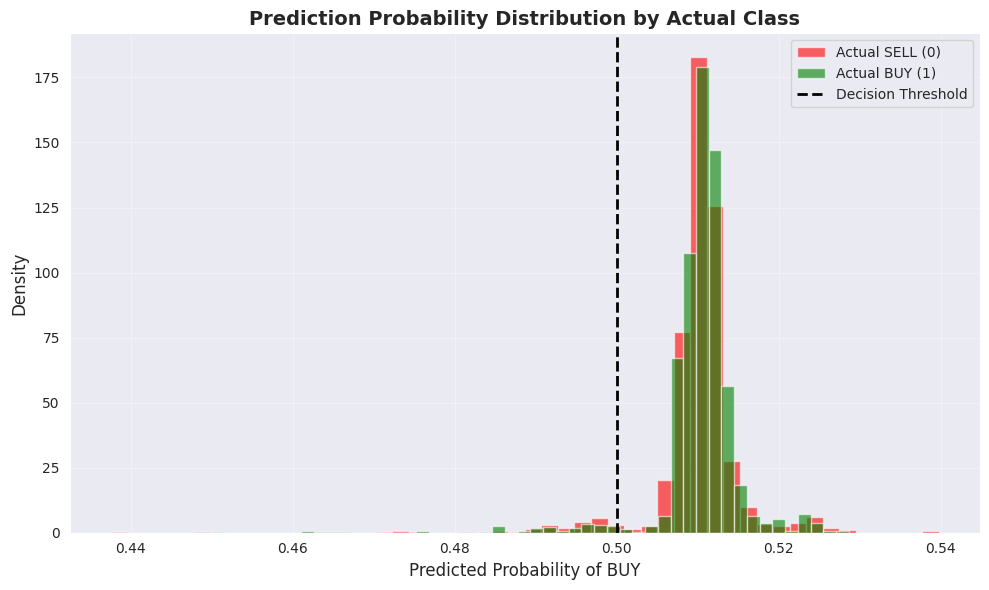


Probability Distribution Statistics:
  Class 0 (SELL): Mean=0.510, Std=0.006
  Class 1 (BUY):  Mean=0.510, Std=0.005


In [ ]:
def plot_prediction_distribution(y_test, y_test_proba):
    """Plot distribution of prediction probabilities by actual class"""
    fig, ax = plt.subplots(figsize=(10, 6))

    # Separate by actual class
    proba_class_0 = y_test_proba[y_test == 0]
    proba_class_1 = y_test_proba[y_test == 1]

    ax.hist(proba_class_0, bins=50, alpha=0.6, label='Actual SELL (0)', color='red', density=True)
    ax.hist(proba_class_1, bins=50, alpha=0.6, label='Actual BUY (1)', color='green', density=True)
    ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')

    ax.set_xlabel('Predicted Probability of BUY', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Prediction Probability Distribution by Actual Class', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nProbability Distribution Statistics:")
    print(f"  Class 0 (SELL): Mean={proba_class_0.mean():.3f}, Std={proba_class_0.std():.3f}")
    print(f"  Class 1 (BUY):  Mean={proba_class_1.mean():.3f}, Std={proba_class_1.std():.3f}")

plot_prediction_distribution(y_test, y_test_pred_proba)

### 7.4 Prediction Confidence Analysis

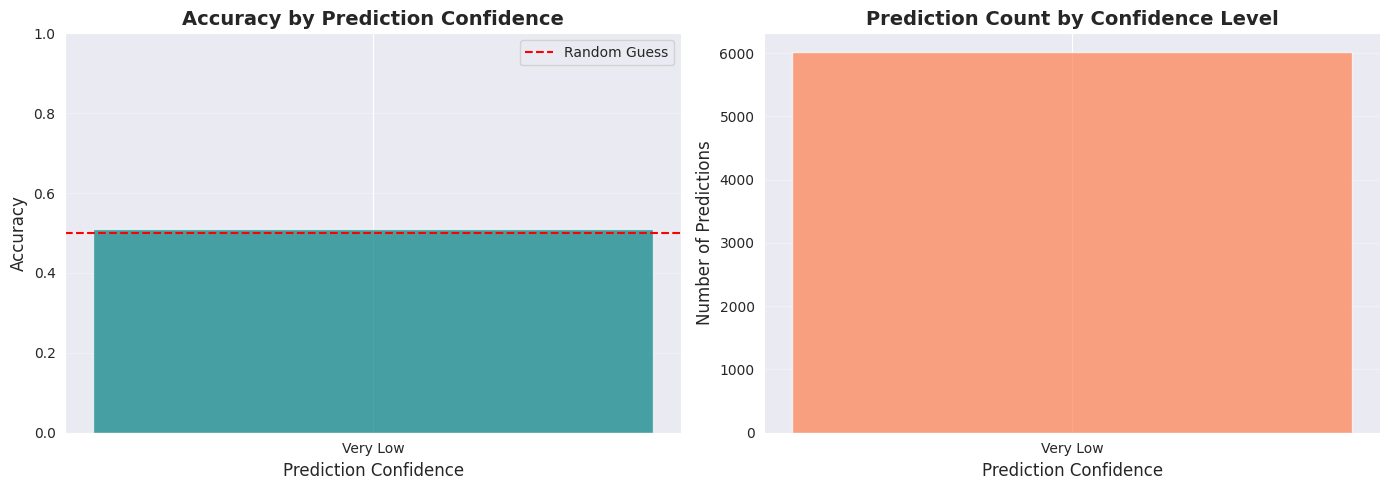


Accuracy by Confidence Level:
Confidence  Accuracy  Count
  Very Low  0.511144   6012


In [ ]:
def analyze_prediction_confidence(y_test, y_test_proba):
    """Analyze model performance by prediction confidence"""

    # Create confidence bins
    confidence = np.abs(y_test_proba - 0.5)  # Distance from decision boundary
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    confidence_category = pd.cut(confidence, bins=bins, labels=labels)

    # Calculate accuracy by confidence level
    results = []
    for cat in labels:
        mask = confidence_category == cat
        if mask.sum() > 0:
            acc = accuracy_score(y_test[mask], (y_test_proba[mask] > 0.5).astype(int))
            count = mask.sum()
            results.append({'Confidence': cat, 'Accuracy': acc, 'Count': count})

    results_df = pd.DataFrame(results)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy by confidence
    axes[0].bar(results_df['Confidence'], results_df['Accuracy'], color='teal', alpha=0.7)
    axes[0].axhline(y=0.5, color='red', linestyle='--', label='Random Guess')
    axes[0].set_xlabel('Prediction Confidence', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Accuracy by Prediction Confidence', fontsize=14, fontweight='bold')
    axes[0].set_ylim([0, 1])
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    # Sample count by confidence
    axes[1].bar(results_df['Confidence'], results_df['Count'], color='coral', alpha=0.7)
    axes[1].set_xlabel('Prediction Confidence', fontsize=12)
    axes[1].set_ylabel('Number of Predictions', fontsize=12)
    axes[1].set_title('Prediction Count by Confidence Level', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    print("\nAccuracy by Confidence Level:")
    print(results_df.to_string(index=False))

analyze_prediction_confidence(y_test, y_test_pred_proba)

## 8. Generate Predictions for Backtesting

In [ ]:
print("Generating Predictions for Backtesting")
print(f"{'-'*60}")

# Create predictions dataframe (for test set only - this is what we'll trade on)
predictions_df = pd.DataFrame({
    'date': X_test.index.get_level_values('Date'),
    'ticker': X_test.index.get_level_values('ticker'),
    'prediction_proba': y_test_pred_proba,
    'prediction': y_test_pred,
    'actual': y_test.values
})

# Reset index
predictions_df = predictions_df.reset_index(drop=True)

# Sort by date and ticker
predictions_df = predictions_df.sort_values(['date', 'ticker'])

print(f"\n✓ Predictions generated")
print(f"  Total predictions: {len(predictions_df):,}")
print(f"  Date range: {predictions_df['date'].min()} to {predictions_df['date'].max()}")
print(f"  Tickers: {predictions_df['ticker'].nunique()}")

print("\nSample predictions:")
print(predictions_df.head(10))

# Statistics
print("\nPrediction Statistics:")
print(f"  BUY signals:  {(predictions_df['prediction'] == 1).sum():,} ({(predictions_df['prediction'] == 1).mean():.1%})")
print(f"  SELL signals: {(predictions_df['prediction'] == 0).sum():,} ({(predictions_df['prediction'] == 0).mean():.1%})")


Generating Predictions for Backtesting
------------------------------------------------------------

✓ Predictions generated
  Total predictions: 6,012
  Date range: 2022-01-03 00:00:00 to 2023-12-29 00:00:00
  Tickers: 12

Sample predictions:
        date ticker  prediction_proba  prediction  actual
0 2022-01-03   AAPL          0.508972           1       0
1 2022-01-03   AMZN          0.509374           1       0
2 2022-01-03    BAC          0.509303           1       1
3 2022-01-03    CVX          0.507461           1       1
4 2022-01-03  GOOGL          0.509683           1       0
5 2022-01-03     GS          0.509777           1       1
6 2022-01-03    JNJ          0.508864           1       1
7 2022-01-03    JPM          0.507385           1       1
8 2022-01-03   MSFT          0.512209           1       0
9 2022-01-03    PFE          0.509205           1       0

Prediction Statistics:
  BUY signals:  5,776 (96.1%)
  SELL signals: 236 (3.9%)


## 9. Save Model and Predictions

In [ ]:
# Save trained model
model_file = DRIVE_PATH / 'trained_model.joblib'
print(f"\nSaving model to: {model_file}")
joblib.dump(model, model_file)
print(f"✓ Model saved")

# Save predictions
predictions_file = DRIVE_PATH / 'predictions.csv'
print(f"\nSaving predictions to: {predictions_file}")
predictions_df.to_csv(predictions_file, index=False)
print(f"✓ Predictions saved")

# Save feature importance
feature_importance_file = DRIVE_PATH / 'feature_importance.csv'
print(f"\nSaving feature importance to: {feature_importance_file}")
feature_importance.to_csv(feature_importance_file, index=False)
print(f"✓ Feature importance saved")

print(f"\n✓ All outputs saved successfully")

## 10. Model Summary Report

In [ ]:
print(f"\n{'='*60}")
print("NOTEBOOK 3 COMPLETE: MODEL TRAINING")
print(f"{'='*60}")

print(f"\n✓ Loaded alpha features from Notebook 2")
print(f"✓ Compared {len(results)} models (Baseline + Advanced)")
print(f"✓ Selected best model: {best_model_name}")
print(f"✓ Generated predictions for backtesting")

print(f"\n Model Comparison Summary:")
print(f"   Baseline Models (Linear):")
for name in ['Logistic Regression', 'Ridge', 'Lasso']:
    if name in results:
        print(f"     {name}: AUC={results[name]['test_auc']:.4f}")
print(f"   Advanced Models (Tree-based):")
for name in ['Random Forest', 'LightGBM', 'XGBoost', 'CatBoost']:
    if name in results:
        print(f"     {name}: AUC={results[name]['test_auc']:.4f}")

print(f"\n Best Model Performance ({best_model_name}):")
print(f"   Test Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"   Test Precision: {test_metrics['precision']:.4f}")
print(f"   Test Recall:    {test_metrics['recall']:.4f}")
print(f"   Test F1 Score:  {test_metrics['f1']:.4f}")
print(f"   Test ROC AUC:   {test_metrics['auc']:.4f}")

print(f"\n Saved Files:")
print(f"   1. {model_file.name} - Trained model")
print(f"   2. {predictions_file.name} - Test predictions")
print(f"   3. {feature_importance_file.name} - Feature rankings")

print(f"\n Top 3 Most Important Features:")
if feature_importance is not None:
    for i, row in feature_importance.head(3).iterrows():
        print(f"   {i+1}. {row['feature']} (importance: {row['importance']:.0f})")
else:
    print(f"   Feature importance not available for {best_model_name}")

print(f"\n Next: Open Notebook 4 (04_Backtesting_Strategy.ipynb)")
print(f"   Input: predictions.csv + market_prices.h5")
print(f"   Output: Performance metrics + equity curves")
print(f"{'='*60}\n")


NOTEBOOK 3 COMPLETE: MODEL TRAINING

✓ Loaded alpha features from Notebook 2
✓ Compared 6 models (Baseline + Advanced)
✓ Selected best model: CatBoost
✓ Generated predictions for backtesting

 Model Comparison Summary:
   Baseline Models (Linear):
     Logistic Regression: AUC=0.5072
     Ridge: AUC=0.5072
     Lasso: AUC=0.5082
   Advanced Models (Tree-based):
     Random Forest: AUC=0.5262
     LightGBM: AUC=0.5183
     CatBoost: AUC=0.5323

 Best Model Performance (CatBoost):
   Test Accuracy:  0.5111
   Test Precision: 0.5087
   Test Recall:    0.9668
   Test F1 Score:  0.6666
   Test ROC AUC:   0.5323

 Saved Files:


NameError: name 'model_file' is not defined